# Ames battery prognosis

Based on article [A Data-Driven Predictive Prognostic Model for Lithium-ion Batteries based on a Deep Learning Algorithm](https://www.mdpi.com/1996-1073/12/4/660).

Dataset available at [NASA Prognostics Center of Excellence](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/).

## Data description

A set of four Li-ion batteries (# 5, 6, 7 and 18) were run through 3 different operational profiles (charge, discharge and impedance) at room temperature. 

- Charging was carried out in a constant current (CC) mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA.

- Discharge was carried out at a constant current (CC) level of 2A until the battery voltage fell to 2.7V, 2.5V, 2.2V and 2.5V for batteries 5 6 7 and 18 respectively. 

- Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep from 0.1Hz to 5kHz.

Repeated charge and discharge cycles result in accelerated aging of the batteries while impedance measurements provide insight into the internal battery parameters that change as aging progresses. The experiments were stopped when the batteries reached end-of-life (EOL) criteria, which was a 30% fade in rated capacity (from 2Ahr to 1.4Ahr). This dataset can be used for the prediction of both remaining charge (for a given discharge cycle) and remaining useful life (RUL).

Data Structure:

- cycle:	top level structure array containing the charge, discharge and impedance operations
	- type: 	operation  type, can be charge, discharge or impedance
	- ambient_temperature:	ambient temperature (degree C)
	- time: 	the date and time of the start of the cycle, in MATLAB  date vector format
	- data:	data structure containing the measurements

	  For charge, the fields are:
		- Voltage_measured: 	Battery terminal voltage (Volts)
		- Current_measured:	Battery output current (Amps)
		- Temperature_measured: 	Battery temperature (degree C)
		- Current_charge:		Current measured at charger (Amps)
		- Voltage_charge:		Voltage measured at charger (Volts)
		- Time:			Time vector for the cycle (secs)

	  For discharge, the fields are:
		- Voltage_measured: 	Battery terminal voltage (Volts)
		- Current_measured:	Battery output current (Amps)
		- Temperature_measured: 	Battery temperature (degree C)
		- Current_charge:		Current measured at load (Amps)
		- Voltage_charge:		Voltage measured at load (Volts)
		- Time:			Time vector for the cycle (secs)
		- Capacity:		Battery capacity (Ahr) for discharge till 2.7V 
	   
    For impedance, the fields are:
		- Sense_current:		Current in sense branch (Amps)
		- Battery_current:	Current in battery branch (Amps)
		- Current_ratio:		Ratio of the above currents 
		- Battery_impedance:	Battery impedance (Ohms) computed from raw data
		- Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms) 
		- Re:			Estimated electrolyte resistance (Ohms)
		- Rct:			Estimated charge transfer resistance (Ohms)


## Environment setup

In [1]:
import os
import zipfile
import csv
from collections import Counter
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
import sklearn

print(f"scikit-learn version: {sklearn.__version__}")
assert sklearn.__version__ >= "0.20"

from sklearn.preprocessing import StandardScaler

scikit-learn version: 0.22.2.post1


## Dataset download and extraction

In [4]:
download_path = "/tmp/"
archive_file_path = download_path + "nasa_ames_battery.zip"

# Download dataset as ZIP archive on local storage
!wget --no-check-certificate https://ti.arc.nasa.gov/c/5/ -O $archive_file_path

--2020-09-24 07:55:56--  https://ti.arc.nasa.gov/c/5/
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://ti.arc.nasa.gov/m/project/prognostic-repository/BatteryAgingARC-FY08Q4.zip [following]
--2020-09-24 07:55:56--  https://ti.arc.nasa.gov/m/project/prognostic-repository/BatteryAgingARC-FY08Q4.zip
Reusing existing connection to ti.arc.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 56517371 (54M) [application/zip]
Saving to: ‘/tmp/nasa_ames_battery.zip’

/tmp/nasa_ames_batt 100%[===================>]  53.90M  38.1MB/s    in 1.4s    

2020-09-24 07:55:57 (38.1 MB/s) - ‘/tmp/nasa_ames_battery.zip’ saved [56517371/56517371]



In [5]:
# Extract ZIP archive
zip_ref = zipfile.ZipFile(archive_file_path, 'r')
zip_ref.extractall(download_path)
zip_ref.close()

## Data plotting for a battery

In [6]:
def get_file_data(mat_file_name):
    """Load a MATLAB file and return its data"""

    mat_file_path = download_path + mat_file_name + ".mat"
    mat_file = scipy.io.loadmat(mat_file_path)
    print(f"File '{mat_file_path}' loaded")

    # Parse file data
    mat_data = mat_file[mat_file_name]
    return mat_data

In [7]:
# Define plotted battery number
battery_number = 5

mat_file_name = "B00" + f"{battery_number:02d}"
mat_data = get_file_data(mat_file_name)

cycles = mat_data[0][0][0][0]
cycle_count = len(cycles)
print(f"{cycle_count} cycles found")

File '/tmp/B0005.mat' loaded
616 cycles found


In [8]:
# Parse battery cycles

cycle_types = []
battery_soh = []
charging_voltages = []
discharging_voltages = []
charging_currents = []
discharging_currents = []
initial_capacity = None

for i, cycle in enumerate(cycles):
    # Cycle structure: type, ambient_temperature, time, data
    cycle_type = cycle[0][0]
    cycle_types.append(cycle_type)
    # print(f"Cycle {i+1}: {cycle_type}")
    cycle_data = cycle[3]

    if cycle_type == "charge" and i == 0:
        # Charge cycle structure: Voltage_measured, Current_measured, Temperature_measured,	Current_charge, Voltage_charge, Time
        charging_voltages = cycle_data[0][0][0][0]
        charging_currents = cycle_data[0][0][1][0]

    elif cycle_type == "discharge":
        # Discharge cycle structure: Voltage_measured, Current_measured, Temperature_measured,	Current_charge, Voltage_charge, Time, Capacity
        cycle_capacity = cycle_data[0][0][6][0][0]
        if initial_capacity == None:
            # First discharging cycle
            initial_capacity = cycle_capacity
            discharging_voltages = cycle_data[0][0][0][0]
            discharging_currents = cycle_data[0][0][1][0]
        battery_soh.append(cycle_capacity / initial_capacity)

print("Cycle types " + str(dict(Counter(cycle_types))))

Cycle types {'charge': 170, 'discharge': 168, 'impedance': 278}


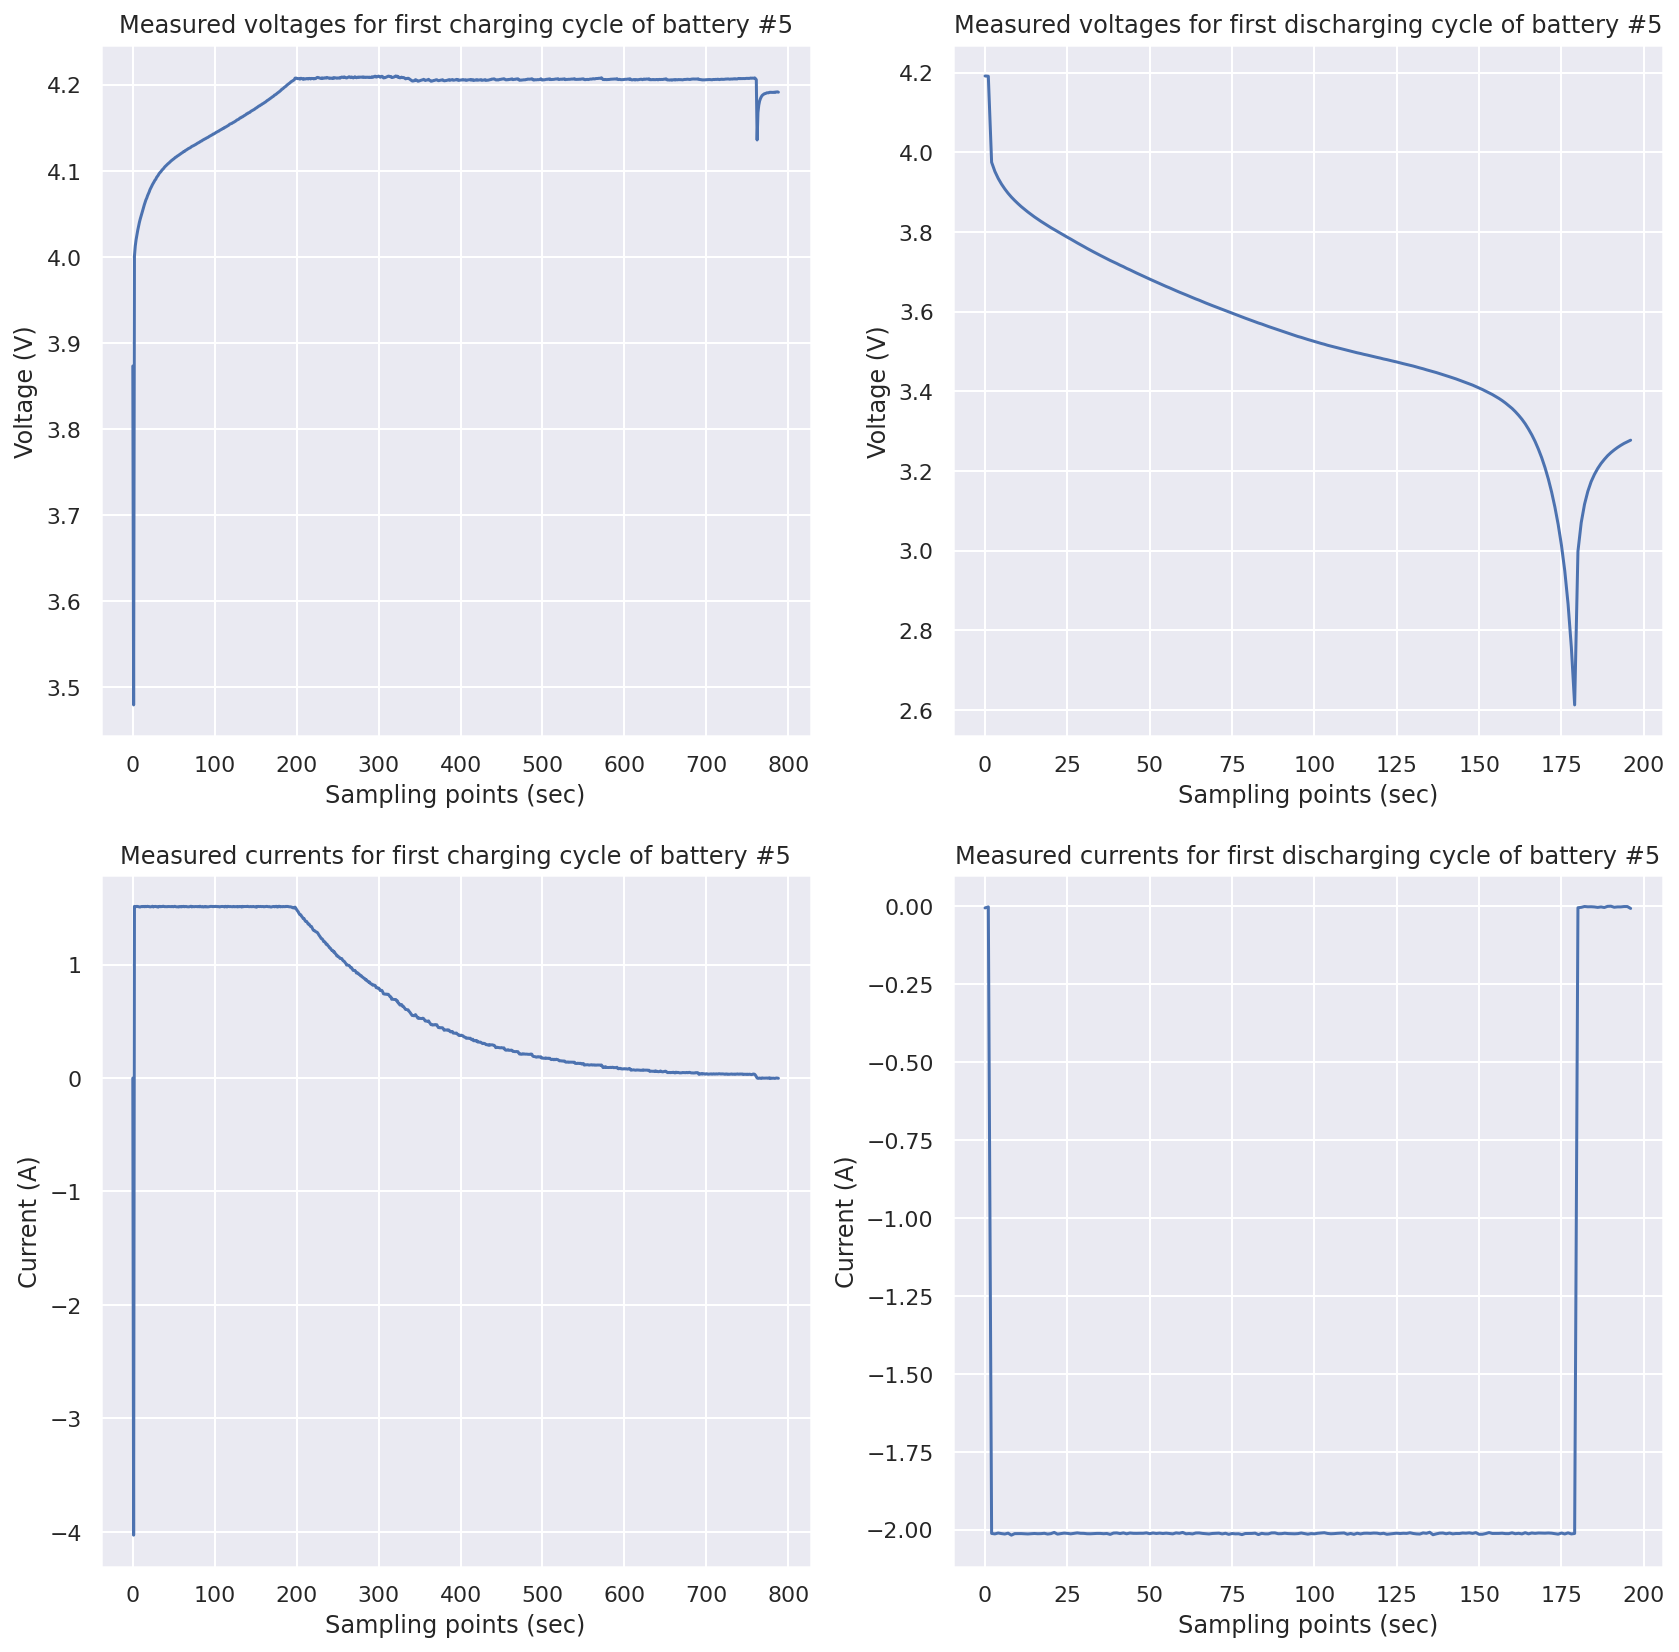

In [9]:
# Plot data for first cycle of battery
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.plot(charging_voltages)
plt.xlabel("Sampling points (sec)")
plt.ylabel("Voltage (V)")
plt.title(f"Measured voltages for first charging cycle of battery #{battery_number}")

# Plot discharging voltages
plt.subplot(2, 2, 2)
plt.plot(discharging_voltages)
plt.xlabel("Sampling points (sec)")
plt.ylabel("Voltage (V)")
plt.title(
    f"Measured voltages for first discharging cycle of battery #{battery_number}"
)

# Plot charging currents
plt.subplot(2, 2, 3)
plt.plot(charging_currents)
plt.xlabel("Sampling points (sec)")
plt.ylabel("Current (A)")
plt.title(f"Measured currents for first charging cycle of battery #{battery_number}")

# Plot discharging currents
plt.subplot(2, 2, 4)
plt.plot(discharging_currents)
plt.xlabel("Sampling points (sec)")
plt.ylabel("Current (A)")
plt.title(
    f"Measured currents for first discharging cycle of battery #{battery_number}"
)

plt.show()

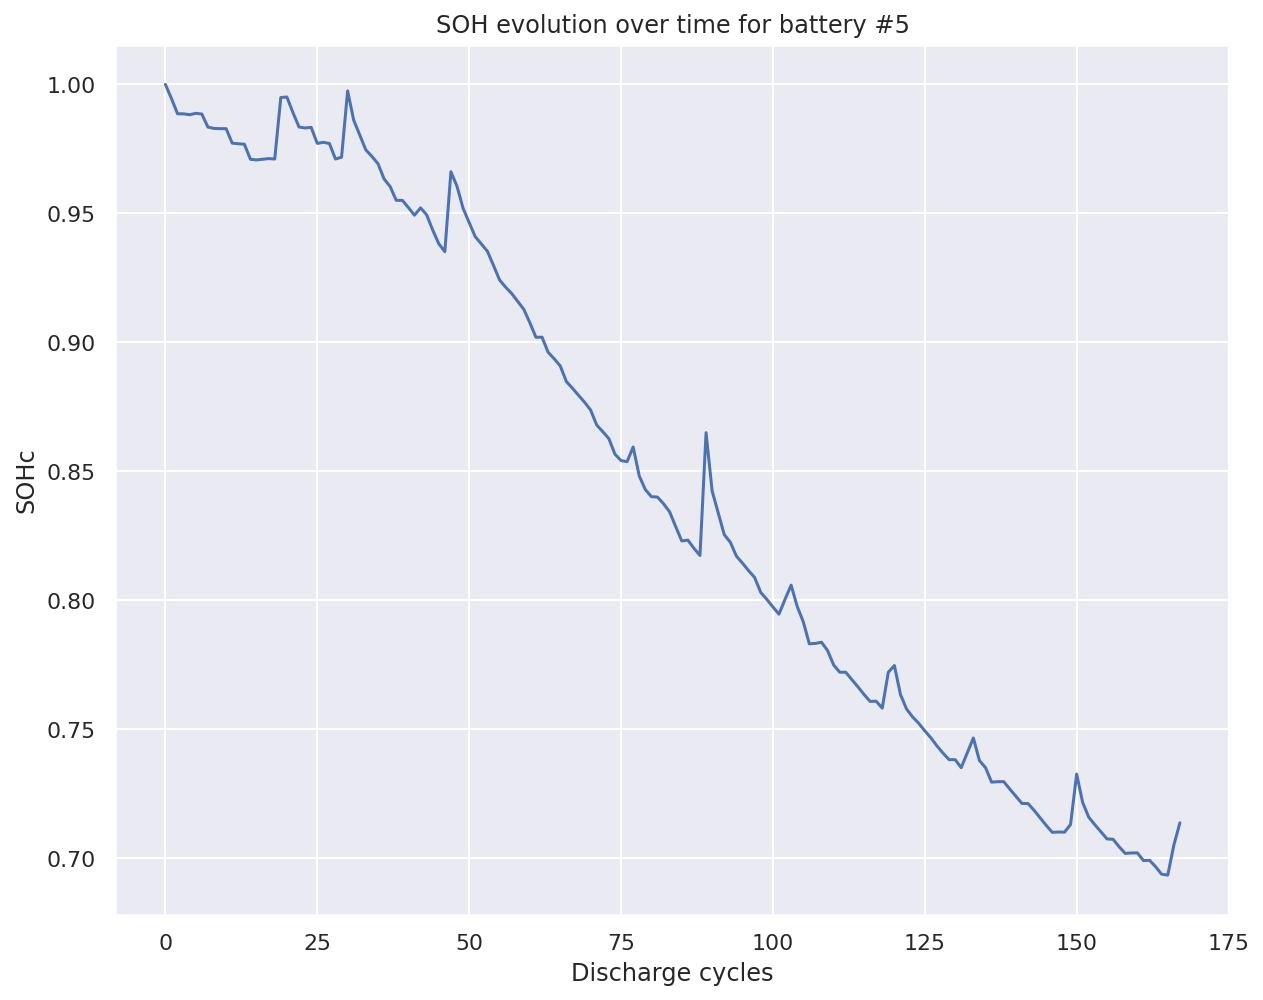

In [10]:
# Plot SOH
plt.figure()
plt.plot(battery_soh)
plt.xlabel("Discharge cycles")
plt.ylabel("SOHc")
plt.title(f"SOH evolution over time for battery #{battery_number}")
plt.show()

## Data export to CSV files

In [19]:
# Export data in CSV form for all batteries in the dataset

battery_numbers = [5, 6, 7, 18]

for battery_number in battery_numbers:
    # Load file data
    mat_file_name = "B00" + f"{battery_number:02d}"
    mat_data = get_file_data(mat_file_name)
    cycles = mat_data[0][0][0][0]

    discharging_data = []

    for cycle in cycles:
        # Cycle structure: type, ambient_temperature, time, data
        cycle_type = cycle[0][0]

        if cycle_type == "discharge":
            # Discharge cycle structure: Voltage_measured, Current_measured, Temperature_measured,	Current_charge, Voltage_charge, Time, Capacity
            cycle_data = cycle[3]
            voltages_measured = cycle_data[0][0][0][0]
            # Last voltage measured for this cycle
            voltage_measured = voltages_measured[-1]
            currents_measured = cycle_data[0][0][1][0]
            # Last current measured for this cycle
            current_measured = currents_measured[-1]
            temperatures_measured = cycle_data[0][0][2][0]
            # Last temperature for this cycle
            temperature_measured = temperatures_measured[-1]
            currents_charge = cycle_data[0][0][3][0]
            # Last charge current for this cycle
            current_charge = currents_charge[-1]
            voltages_charge = cycle_data[0][0][4][0]
            # Last charge voltage for this cycle
            voltage_charge = voltages_charge[-1]
            # Capacity for this cycle
            capacity = cycle_data[0][0][6][0][0]
            discharging_data.append(
                [
                    voltage_measured,
                    current_measured,
                    temperature_measured,
                    current_charge,
                    voltage_charge,
                    capacity,
                ]
            )

    # Create CSV file
    export_file_name = mat_file_name + ".csv"
    export_file_path = download_path + export_file_name
    with open(export_file_path, "w", newline="") as file:
        writer = csv.writer(file)
        # Write header (columns names)
        writer.writerow(
            [
                "Voltage_measured",
                "Current_measured",
                "Temperature_measured",
                "Current_charge",
                "Voltage_charge",
                "Capacity",
            ]
        )
        # Write data
        writer.writerows(discharging_data)
        print(f"File '{export_file_path}' created successfully")

File '/tmp/B0005.mat' loaded
File '/tmp/B0005.csv' created successfully
File '/tmp/B0006.mat' loaded
File '/tmp/B0006.csv' created successfully
File '/tmp/B0007.mat' loaded
File '/tmp/B0007.csv' created successfully
File '/tmp/B0018.mat' loaded
File '/tmp/B0018.csv' created successfully


## Data analysis

In [20]:
df_battery = pd.read_csv(download_path + "B0005.csv")
print(f"Dataset shape: {df_battery.shape}")

Dataset shape: (168, 6)


In [13]:
# To be continued...

## Data preprocessing

In [14]:
def prepare_dataset(battery_number):
    ### Split a battery dataset between inputs and outputs"""

    battery_file_name = "B00" + f"{battery_number:02d}"
    df_battery = pd.read_csv(download_path + battery_file_name + ".csv")
    
    # Split dataset between input and target data
    x = df_battery.drop("Capacity", axis=1).to_numpy()
    y = df_battery["Capacity"].to_numpy()

    # Standardize input data
    x = StandardScaler().fit_transform(x)
    
    return (x, y)

In [21]:
x_train_5, y_train_5 = prepare_dataset(5)
print(f"x_train_5: {x_train_5.shape}. y_train_5: {y_train_5.shape}")

x_train_5: (168, 5). y_train_5: (168,)


## Training models

In [16]:
# To be continued...

## SOH prediction

In [17]:
# To be continued...